# Class Activation Map with Keras

Examples with Class Activation Map

The notebook can be run eiher locally or in Google Colaboratory (<https://colab.research.google.com>)

The `ENVIRONMENT` variable must be set accordingly (`LOCAL` or `CLOUD`)

If run on the Google Colab, the image must be uploaded first (Left pane -> Files -> UPLOAD).

It is better to change the runtime to increase the computation power (Runtime -> Change runtime type -> GPU).



In [13]:
from tensorflow.keras import activations
#from keras.applications import vgg16 # NOTE: maybe need to have tensorflow.keras. instead of keras.
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input 
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.preprocessing import image

import matplotlib.cm as cm
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

# Get the path of the notebook
from pathlib import Path
CURRENT_PATH = Path('.').resolve()

ENVIRONMENT = 'CLOUD' # Possible values: 'LOCAL' or 'CLOUD' (for Google Colab)
IMAGES_FOLDER = 'images'

## Load the model
The model is loaded with the ImageNet weigths. The model is taken as is, without re-training any layer.

In [14]:
model = VGG16(weights='imagenet')

## Load an image 
The image is loaded an convert to a numpy array
At first the image is loaded in PIL format (width, height, channel) and then transform in numpy (height, width, channel).

In [35]:
#IMAGE_2_PROCESS = 'cat01.jpg' # If on the cloud, the image must be uploaded first
#IMAGE_2_PROCESS = 'cow.jpg' # If on the cloud, the image must be uploaded first
#IMAGE_2_PROCESS = 'miniskirt.jpg' # If on the cloud, the image must be uploaded first
#IMAGE_2_PROCESS = 'soccer02.jpg' # If on the cloud, the image must be uploaded first
#IMAGE_2_PROCESS = 'soccer03.jpg' # If on the cloud, the image must be uploaded first
IMAGE_2_PROCESS = 'cow.jpg' # If on the cloud, the image must be uploaded first


Image batch size (1, 224, 224, 3)


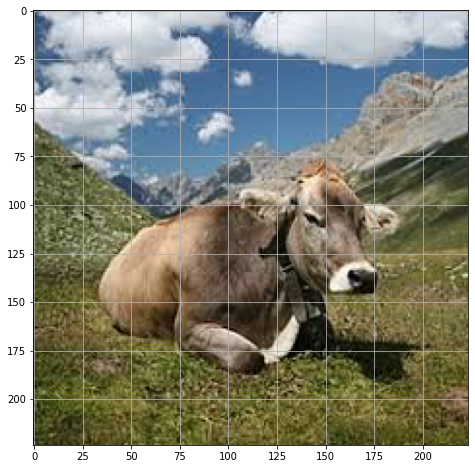

In [36]:
filename = f'{CURRENT_PATH}/{IMAGES_FOLDER}/{IMAGE_2_PROCESS}' if ENVIRONMENT == 'LOCAL' else IMAGE_2_PROCESS
# Load an image in PIL format
original = image.load_img(filename, target_size=(224, 224))
# Convert it to a numpy array 
numpy_image = image.img_to_array(original)
# Add a dimension to the image (batchsize, height, width, channels)
image_input = np.expand_dims(numpy_image, axis=0)
print(f'Image batch size {image_input.shape}')
pl.figure(figsize=(8,8))
pl.grid(True)
pl.imshow(np.uint8(image_input[0]))

## Predict classes
The image can be processed to match the input of the model and it can do prediction on the processed image.

In [37]:
# Prepare the image for the model
processed_image = preprocess_input(image_input.copy())
# Get the predicted probabilities for each class
predictions = model.predict(processed_image)
# Get the top 5 predictions
label = decode_predictions(predictions)
print(label)

[[('n02403003', 'ox', 0.43208575), ('n02412080', 'ram', 0.10943911), ('n02415577', 'bighorn', 0.060929675), ('n02417914', 'ibex', 0.05272968), ('n02408429', 'water_buffalo', 0.045004338)]]


## CAM visualization

The CAM visualization is done using tf-Keras-vis (<https://github.com/keisen/tf-keras-vis/>).

The model returns a probability for each classes. We need to know the ID of the class we are predicting in order to apply the right heatmap on the original image.
List of mapping between classes and IDs is available here: <https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a>.

**vanilla**: No modification of backpropagation

**guided**: Only propagate positive gradients for positive activations. We are only interested in what the image features the neuron detects, not what it doesn't detect. When propagating the gradient, all negative gradients are set to 0.

In [38]:
!pip install tf-keras-vis

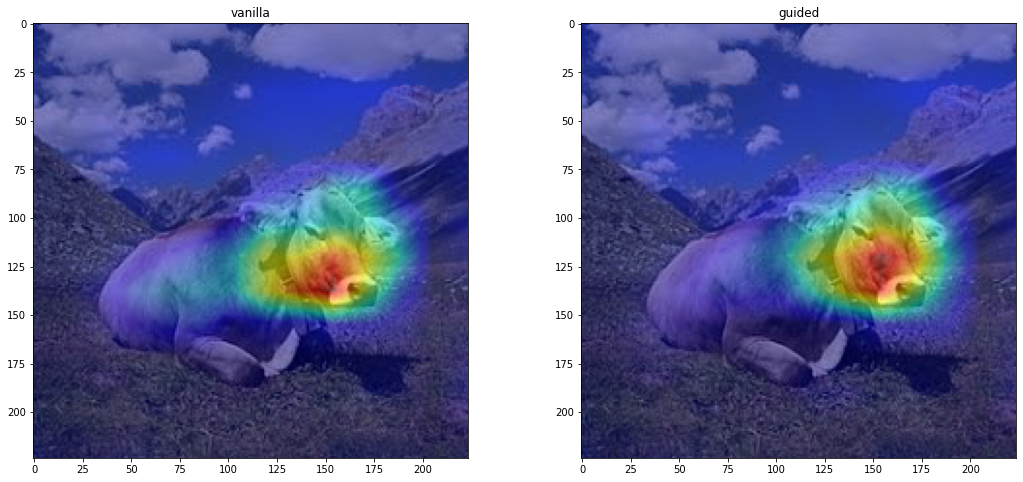

<Figure size 1296x576 with 0 Axes>

In [70]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, GuidedBackpropagation
from tf_keras_vis.utils.scores import CategoricalScore

gradcams = [
    # Not guided
    Gradcam(model, model_modifier=[
      ReplaceToLinear(),
    ], clone=True),
    
    # Guided
    Gradcam(model, model_modifier=[
        ReplaceToLinear(),
        GuidedBackpropagation()
    ], clone=True),
]

IMAGE_INDEX = np.argmax(predictions)

# We create a list of Class Activation Map (CAM) made with guided and 
# without guided backprop  
cam_list = [
    gradcam(CategoricalScore(IMAGE_INDEX), numpy_image)
    for gradcam in gradcams
]

fig, ax = pl.subplots(1, len(cam_list), figsize=(18, 8))

pl.figure(figsize=(18,8))

titles = ["vanilla", "guided"]

# We plot the heatmaps
for cam_idx, cam in enumerate(cam_list):
    ax[cam_idx].set_title(titles[cam_idx])
    ax[cam_idx].imshow(np.uint8(image_input[0]))
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    ax[cam_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay

## Questions

1. Compute the activation map for all the images we give you.
2. Do the maps reflect the class of the pictures?
3. Are there images in which the activation maps highlight zones that do not belong to the object? Which ones?
4. Look at the provided images and observe the images that were used to train the classifier on these specific classes (i.e., soccer ball). Do you think that all images have been labelled appropriately ? explain.
5. Hypothesize about the behavior of the network observed in 3.